In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch import nn
from torchvision import datasets, transforms
from typing import Union, Tuple
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from tqdm import tqdm

from pdb import set_trace

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True


In [3]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


Download cifar10 and separate into dataloaders

In [4]:
# mean = (0.4914, 0.4822, 0.4465)
# std = (0.247, 0.243, 0.261)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
#download cifar10 data and separate it into train, validation and test
d = datasets.CIFAR10('../data', train=True, download=True, transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                            ]))

random_seed = 42
torch.manual_seed(random_seed);
val_size = int(0.2*len(d))
train_size = int(len(d)-val_size)
train_ds, val_ds = random_split(d, [train_size, val_size])


train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=128*2, shuffle=True, num_workers=2)


d_t=datasets.CIFAR10('../data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                        ]))
test_dl = torch.utils.data.DataLoader(d_t,
    batch_size=128*2, shuffle=True, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [5]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [6]:
print(get_mean_and_std(test_dl))

(tensor([0.4953, 0.4859, 0.4519]), tensor([0.2468, 0.2431, 0.2619]))


In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(28, 28))
        ax.set_xticks([]); ax.set_yticks([])
        # ax.imshow(make_grid(to_device(transforms.Normalize(-np.array(mean)/std, 1.0/np.array(std))(images),"cpu"), nrow=16).permute(1, 2, 0)) ##denormalize
        ax.imshow(make_grid(to_device(images,"cpu"), nrow=16).permute(1, 2, 0)) ##denormalize
        break
        

Create the model for cifar10


In [8]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader(): #wrap a dataloader to move data to a device
  def __init__(self, dl, device): 
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)
 #yield a batch of data after moving it to a device

  def __len__(self):
    return len(self.dl) #number of batches

CUDA Available:  True


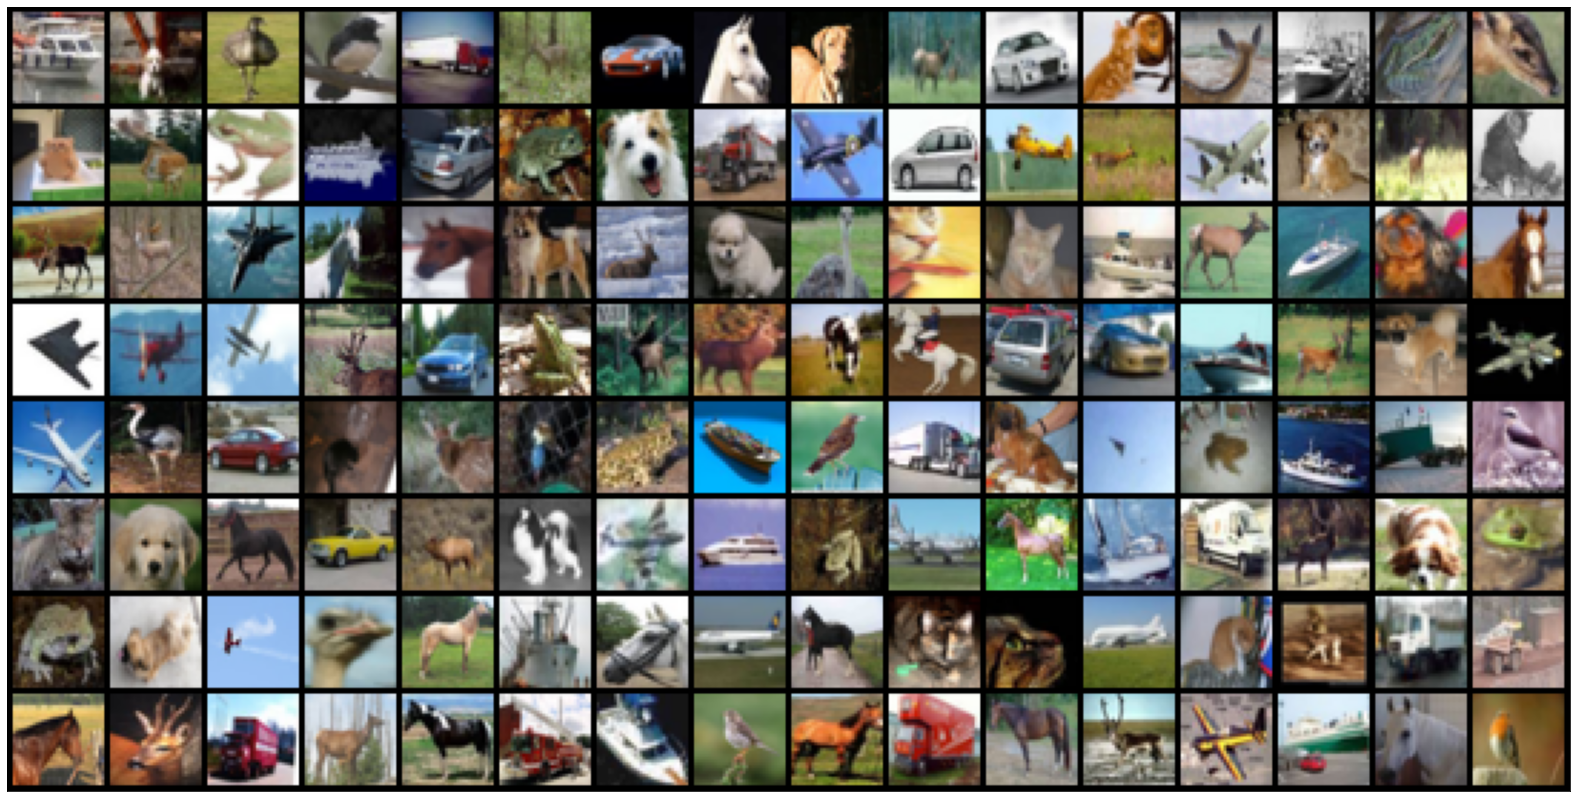

In [9]:
show_batch(train_dl)

In [10]:
class myCNN(nn.Module):
  def training_step(self,batch):
    images, labels = batch
    images,labels = images.to(device), labels.to(device)
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images, labels = batch
    images,labels = images.to(device), labels.to(device)
    out = self(images)
    
    out =out.to(device)
    
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class CIFARModel(myCNN):
    def __init__(self):
        self.num_chanels = 3
        self.num_classes = 10
        self.img_size = 32
        super(CIFARModel, self).__init__()
        self.network = nn.Sequential(
          
          nn.Conv2d(self.num_chanels, 64, kernel_size=3),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.MaxPool2d(2,stride = 2),
          nn.Conv2d(64, 128, kernel_size=3),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.MaxPool2d(2,stride = 2),
          nn.Flatten(),
          nn.Dropout(p=0.2),
          nn.Linear(128*5*5, 256),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(256, self.num_classes)
        )

    def forward(self, x):
        # print(x.shape)
        return F.softmax(self.network(x),dim=1)


In [12]:
model = CIFARModel()
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
to_device(model, device)

CIFARModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): Dropout(p=0.2, inplace=False)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): Dropout(p=0.2, inplace=False)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=3200, out_features=256, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.2, inplace=False)
    (19): Linear(in_features=256, out_features=256, bias=True)
    (20): ReLU()
    (21): Dropout(p=0.2, inplace=False)
    (22):

In [13]:
@torch.no_grad()

def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit (epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): 
  history = []
  optimizer = opt_func(model.parameters(), lr, weight_decay=(lr/epochs),momentum = 0.9)#1e-6
  for epoch in range(epochs):
    if (epoch % 10==0 and epoch > 5):
      optimizer = opt_func(model.parameters(), lr/10, weight_decay=(lr/epochs),momentum = 0.9)#1e-6
    model.train()
    train_losses = []
    #train
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #validate
    result = evaluate(model,val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [14]:
num_epochs = 50
# opt_func = torch.optim.Adam
# opt_func = torch.optim.Adagrad
lr = 0.01

In [ ]:
history = fit(num_epochs, lr, model,train_dl, val_dl, opt_func = torch.optim.SGD)

KeyboardInterrupt: ignored

In [15]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of epochs')

In [ ]:
plot_losses(history)

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

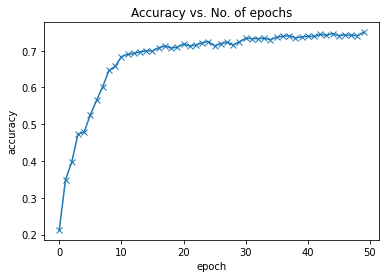

In [ ]:
plot_accuracies(history)

In [ ]:
model.eval
result = evaluate(model, test_dl)
result

{'val_loss': 2.3026130199432373, 'val_acc': 0.09765625}

In [ ]:
torch.save(model.state_dict(), "/content/model")

In [15]:
model.load_state_dict(torch.load("/home/roberto/Desktop/tfg/model (1)",map_location=torch.device(device)))
model.eval()
evaluate(model,test_dl)

{'val_loss': 1.7957390546798706, 'val_acc': 0.7391601800918579}

In [16]:
BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

In [78]:
def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01,im_start=False) :

    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x,labels) :

        outputs = model(x).to(device)
        labels = labels.to(device)
        ou = outputs[0].to('cpu')
        la = labels.to('cpu')
        one_hot_labels = torch.eye(len(ou))[la].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    if im_start:
        w=images
    else:
        w = torch.zeros_like(images, requires_grad=True).to(device)
    
    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10
    
    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        # loss1=0
        loss2 = torch.sum(c*f(a,labels))
        
        cost = loss1 + loss2
        # print(cost)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost,loss1
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    return attack_images,loss1

In [79]:
def denormalize(imagess):
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    mean = np.array(mean)
    std = np.array(std)
    imagess = imagess * std[:, None, None] + mean[:, None, None]
    return imagess

In [87]:
lbls = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def visualize(images, adversarials, reals, labels, predicted, modiff, number,target=-1,save=""):
    # adversarials = adversarials + images
    # images = torch.clamp(images,0,1)
    # adversarials = torch.clamp(adversarials,0,1)
    # images = denormalize(images.cpu().detach().numpy())
    # adversarials = denormalize(adversarials.cpu().detach().numpy())
    adversarials= adversarials.cpu().detach().numpy()
    images = images.cpu().detach().numpy()
    modiff = modiff.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    reals = reals.cpu().detach().numpy()
    predicted = predicted.cpu().detach().numpy()
    images = np.transpose(images, [0, 2, 3, 1])
    adversarials = np.transpose(adversarials, [0, 2, 3, 1])
    modiff = np.transpose(modiff, [0, 2, 3, 1])
    # adversarials = np.round(adversarials*255).astype(int)
    # images = np.round(images*255).astype(int)

    if(number>0):
      fig, axes = plt.subplots(3, number, figsize=(5*number, 12))
      count = i = j = 0
      
      while count != number and i<len(labels):
        if(target<0):
          while (labels[i]!=reals[i] or predicted[i]==reals[i]) and i<len(labels)-1:
            i+=1
          if((labels[i]!=reals[i] or predicted[i]==labels[i])):
            break
        else:
          while (labels[i]!=reals[i] or predicted[i]==reals[i] or predicted[i]!=target) and i<len(labels)-1:
            i+=1
          if(labels[i]!=reals[i] or predicted[i]==labels[i]or predicted[i]!=target):
            break
        
        if number>1:
          count+=1
          axes[0, j].imshow(images[i])
          axes[1, j].imshow(adversarials[i])
          axes[2, j].imshow(modiff[i])
          axes[0, j].set_title("Original: {}".format(lbls[labels[i]]))
          axes[1, j].set_title("Adversarial: {}".format(lbls[predicted[i]]))
          axes[2, j].set_title("modiff: ")
          axes[0, j].axis('off')
          axes[1, j].axis('off')
          axes[2, j].axis('off')
          i+=1
          j+=1
        else:
          count+=1
          axes[0].imshow(images[i])
          axes[1].imshow(adversarials[i])
          axes[2].imshow(modiff[i])
          axes[0].set_title("Original: {}".format(lbls[labels[i]]))
          axes[1].set_title("Adversarial: {}".format(lbls[predicted[i]]))
          axes[2].set_title("modiff: ")
          axes[0].axis('off')
          axes[1].axis('off')
          axes[2].axis('off')
      plt.show()
      if save!="":
        plt.savefig('C&W_L2_'+save+'.pdf',format='pdf',bbox_inches='tight')
      

In [90]:
def untargeted(c=2,im_start=False): #if im_start = true the optimization will start with the original image instead of random noise, so it wont have into account the c, the results will be a modification of all the pixels resulting on a grayish image, but the attack success rate is low, a 35-40% 
  print("Attack Image & predict label")
  model.eval()
  misclassified = to_count = total = correct = 0
  aux=0
  perturbed_images = []
  normal_images = []
  perturbed_labels = []
  predicted_labels = []
  normal_labels = []
  differences = []
  l=0
  for images, labels in test_dl:
      aux+=1
      iter_vis=0
      images = images.to(device)
      p_labels  = torch.max(model(images).data, 1)[1].to(device)

      images2,loss = cw_l2_attack(model, images, p_labels, targeted = False, c=c,im_start=im_start )
      
      labels = to_device(labels, device)
      outputs = model(images2)

      _, predicted = torch.max(outputs.data, 1)
      # set_trace()
      total += len(images)
      for i in range(len(predicted)):
        if p_labels[i]==labels[i]:
          to_count +=1
          if p_labels[i]!=predicted[i]:
            iter_vis+=1
            misclassified+=1
          else:
            correct += 1
      l+=loss
      A = (images2-images)
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      A+=0.5

      # print(len(labels), len(p_labels), len(predicted))
      # number = min(18,iter_vis)
      # visualize(images,images2, labels, p_labels, predicted,A, number)
      # if(aux%10==0):
      #   visualize(images,images2, labels, p_labels, predicted,A, number)
      perturbed_images.append(images2)
      normal_images.append(images)
      perturbed_labels.append(p_labels)
      predicted_labels.append(predicted)
      normal_labels.append(labels)
      differences.append(A)
  print('Correctamente etiquetados: ', to_count ,'Misclassified: ', misclassified, 'Correct: ', correct, 'Total: ',total, 'Incorrectos: ', total-to_count)
  visualize(torch.cat(normal_images),torch.cat(perturbed_images), torch.cat(normal_labels), torch.cat(perturbed_labels), torch.cat(predicted_labels),torch.cat(differences), 5, save="c"+str(c))
  A_sr =  misclassified / to_count
  P_sr = correct / total
  print('Accuracy of the network on the', to_count,' test images: %d %%' % (100 * A_sr))
  l /= len(test_dl)
  print('Loss: ', l)
  return misclassified, correct,l

  0%|          | 0/1 [00:00<?, ?it/s]

c=  1000
Attack Image & predict label


<ipython-input-78-23fc3701426e>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())


Correctamente etiquetados:  7404 Misclassified:  7398 Correct:  6 Total:  10000 Incorrectos:  2596


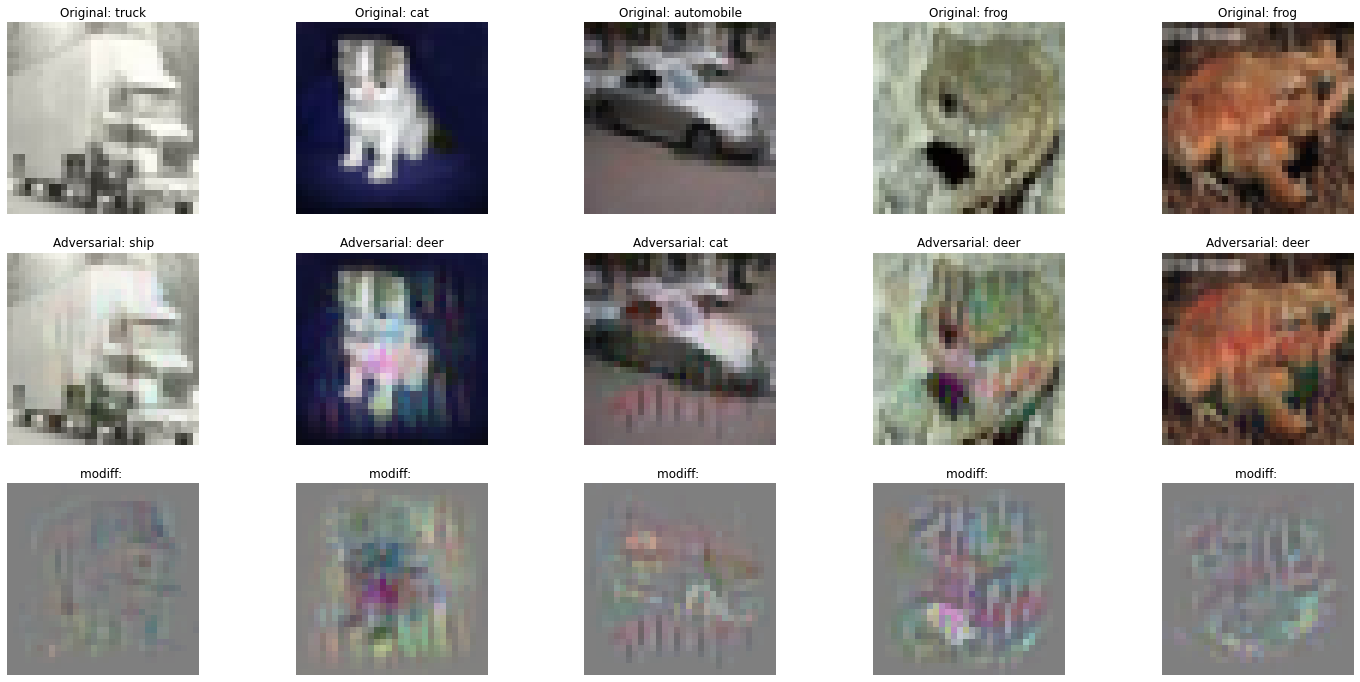

100%|██████████| 1/1 [13:31<00:00, 811.26s/it]

Accuracy of the network on the 7404  test images: 99 %
Loss:  tensor(1328.2963, device='cuda:0', grad_fn=<DivBackward0>)


<Figure size 432x288 with 0 Axes>

In [92]:
v_c = [0.01,0.1,1,10,100,1000]
acc = []
l = []
for c in tqdm(v_c):
  print("c= ",c)
  m,c,loss=untargeted(c,False)
  acc.append(m/(m+c))
  l.append(loss)


In [70]:
def plot_accuracies(c,acc,loss):
    aux = [r'$1 e-02$',r'$1 e-01$',r'$1 e+00$',r'$1 e+01$',r'$1 e+02$',r'$1 e+03$']
    fig, ax = plt.subplots()


    ax.plot(range(len(c)),acc,color='blue')
    ax.xlabel(r'$C$')
    ax.xticks(range(len(c)),aux)
    ax.ylabel('Attack Success Rate',color='blue')

    ax2 = ax.twinx()
    ax2.plot(range(len(c)),loss,color='red')
    ax2.ylabel('Mean adversarial example distance',color='red')

    plt.ylabel('Attack Success Rate')
    # plt.title('Attack Success Rate vs. ' r'$C$')
    plt.savefig("C&W_L2_Untargeted.pdf", format = 'pdf', bbox_inches='tight')

In [ ]:
def plot_modelsr(c,acc):
    aux = [r'$1 e-02$',r'$1 e-01$',r'$1 e+00$',r'$1 e+01$',r'$1 e+02$',r'$1 e+03$']
    fig, ax = plt.subplots()


    ax.plot(range(len(c)),acc,color='blue')
    ax.xlabel(r'$C$')
    ax.xticks(range(len(c)),aux)
    ax.ylabel('Attack Success Rate',color='blue')

    ax2 = ax.twinx()
    ax2.plot(range(len(c)),loss,color='red')
    ax2.ylabel('Mean adversarial example distance',color='red')

    plt.ylabel('Attack Success Rate')
    # plt.title('Attack Success Rate vs. ' r'$C$')
    plt.savefig("C&W_L2_Untargeted.pdf", format = 'pdf', bbox_inches='tight')

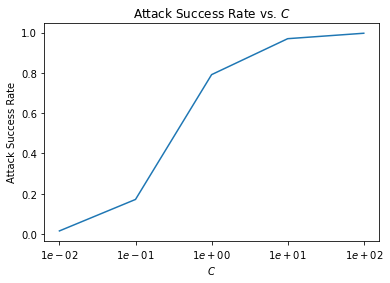

In [71]:
plot_accuracies(v_c,acc,l)

In [ ]:
def to_full(images):
    images = images * 255
    return images

In [ ]:
lbls = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


Targeted

In [ ]:
print(len(test_dl))

40


In [85]:
def targeted(c=2,t=0,im_start=False):
  print("Attack Image & predict label")
  model.eval()
  misclassified = to_count = total = correct = 0
  aux=0

  perturbed_images = []
  normal_images = []
  perturbed_labels = []
  predicted_labels = []
  normal_labels = []
  differences = []
  l=0
  for images, labels in tqdm(test_dl):
      aux+=1
      iter_vis=0
      images = images.to(device)
      p_labels  = torch.max(model(images).data, 1)[1].to(device)
      target = torch.full((images.shape[0],), t).to(device)

      images2, loss = cw_l2_attack(model, images, target, targeted = True, c=c,im_start=im_start )
      
      labels = to_device(labels, device)
      outputs = model(images2)

      _, predicted = torch.max(outputs.data, 1)
      # set_trace()
      total += len(images)
      for i in range(len(predicted)):
        if p_labels[i]==labels[i]:
          if p_labels[i]!=t:
            to_count +=1
            if predicted[i]==t:
              iter_vis+=1
              misclassified+=1
            else:
              correct += 1
      l+=loss
      A = (images2-images)
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      A+=0.5
      # print(len(labels), len(p_labels), len(predicted))
      # number = min(5,iter_vis)
      # if(aux%10==0):
      #   visualize(images,images2, labels, p_labels, predicted,A, number,t)

      perturbed_images.append(images2)
      normal_images.append(images)
      perturbed_labels.append(p_labels)
      predicted_labels.append(predicted)
      normal_labels.append(labels)
      differences.append(A)
  print('Correctamente etiquetados: ', to_count ,'Misclassified: ', misclassified, 'Correct: ', correct, 'Total: ',total, 'Incorrectos: ', total-to_count)
  visualize(torch.cat(normal_images),torch.cat(perturbed_images), torch.cat(normal_labels), torch.cat(perturbed_labels), torch.cat(predicted_labels),torch.cat(differences), 5, save="targed-"+str(t)+"c"+str(c))
  A_sr =  misclassified / to_count
  P_sr = correct / total
  print('Accuracy of the network on the', to_count,' test images: %d %%' % (100 * A_sr))
  l /= len(test_dl)
  print('Loss: ', l)
  return misclassified, correct, l

In [86]:
v_c = [0.01,0.1,1,10,100]
acc = []
l = []
for c in tqdm(v_c):
  print("c= ",c)
  m_t,c_t,loss_t=targeted(c,9,False)
  acc.append(m_t/(m_t+c_t))
  l.append(loss_t)

  0%|          | 0/5 [00:00<?, ?it/s]

c=  0.01
Attack Image & predict label


<ipython-input-78-23fc3701426e>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/5 [00:08<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_accuracies(v_c,acc,l)